In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
from scipy.stats import binned_statistic, binned_statistic_dd


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [2]:
counts_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/histogram_counts'

In [3]:
def get_lhd_db(h1, h2, eps=1e-12):
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]

    log_diff_dB = 10 * (np.log10(h1) - np.log10(h2))
    lhd_db = np.sqrt(np.mean(log_diff_dB ** 2))
    
    return lhd_db

def get_lhd(h1, h2):
    # Convert to arrays in case they're lists
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]
    
    return np.sum(np.abs(np.log1p(h1) - np.log1p(h2)))

def write_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,lhd_db):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['lhd_db'].append(lhd_db)
    

In [4]:
'''
LHD
'''

bins = np.arange(1, 1051, 20)

def get_lhd_df(start,end):
    
    result_dict = {'GCM':[],'ml_type':[],'framework':[],'period':[],'sample_n':[],'lhd_db':[],'epoch':[]}

    for epoch in [120,125,130]:
        for gcm in ['EC-Earth3','NorESM2-MM']:
            for ml_type in ['GAN','unet']:
                for framework in ['perfect','imperfect']:

                    df = pd.read_csv(f'{counts_dir}/{gcm}_{ml_type}_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)

                    ccam_counts = df['CCAM']

                    for i,n in enumerate([5,10,20,60,100,140]):

                        ml_counts = df[str(n)]

                        lhd_db = get_lhd_db(ml_counts,ccam_counts)

                        write_to_dict(result_dict,f'{start}-{end}',epoch,gcm,ml_type,framework,n,lhd_db)

    df = pd.DataFrame.from_dict(result_dict)
    
    return(df)


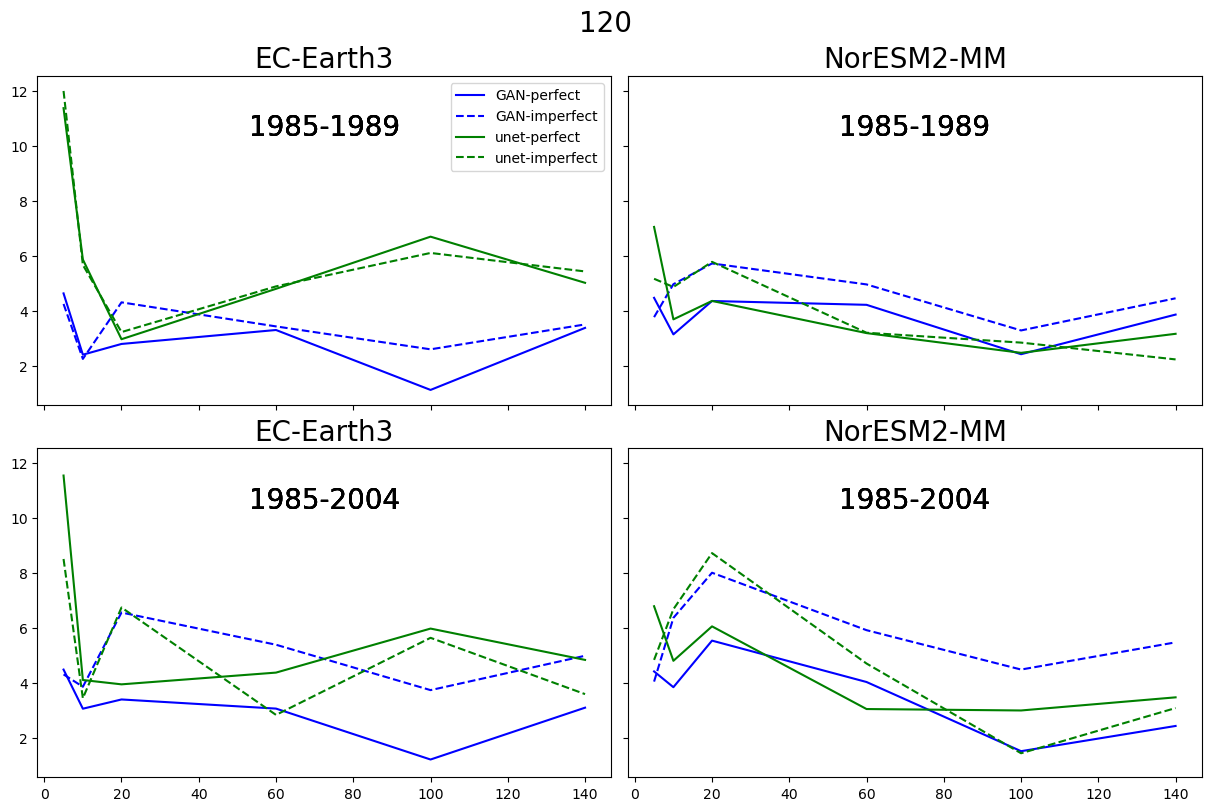

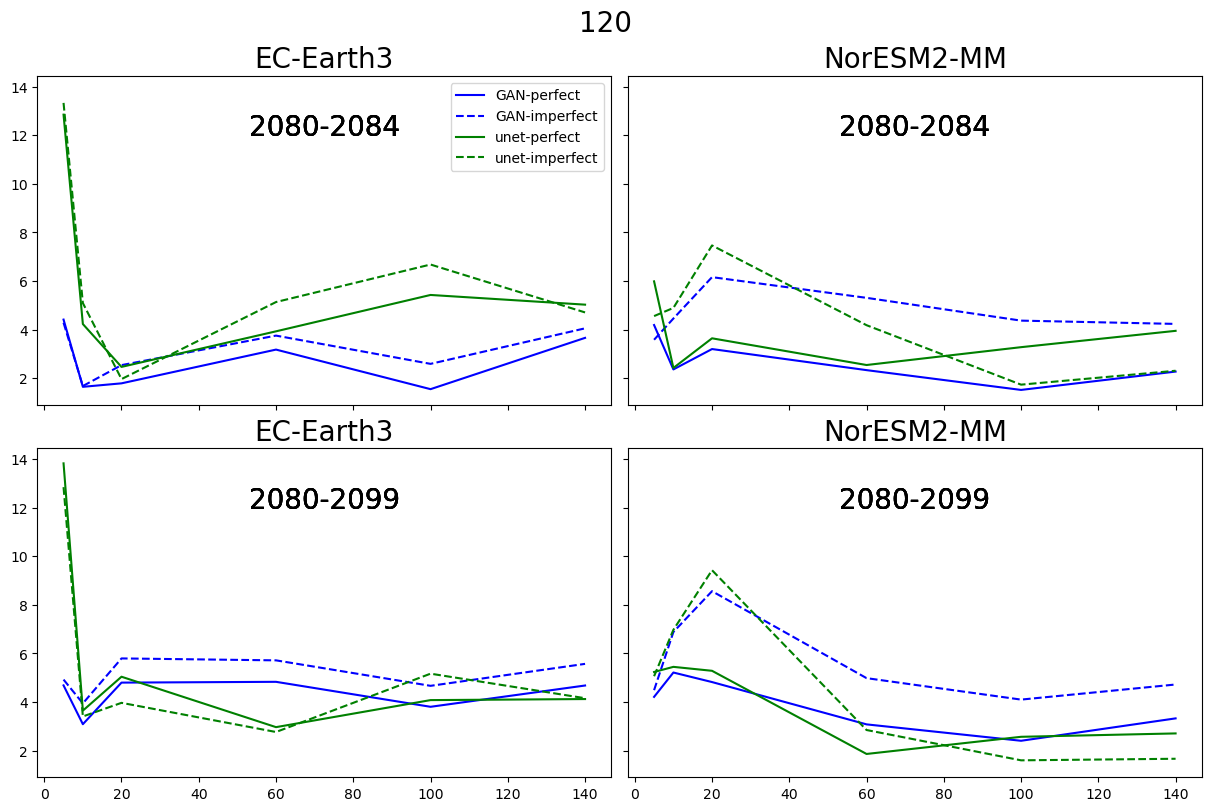

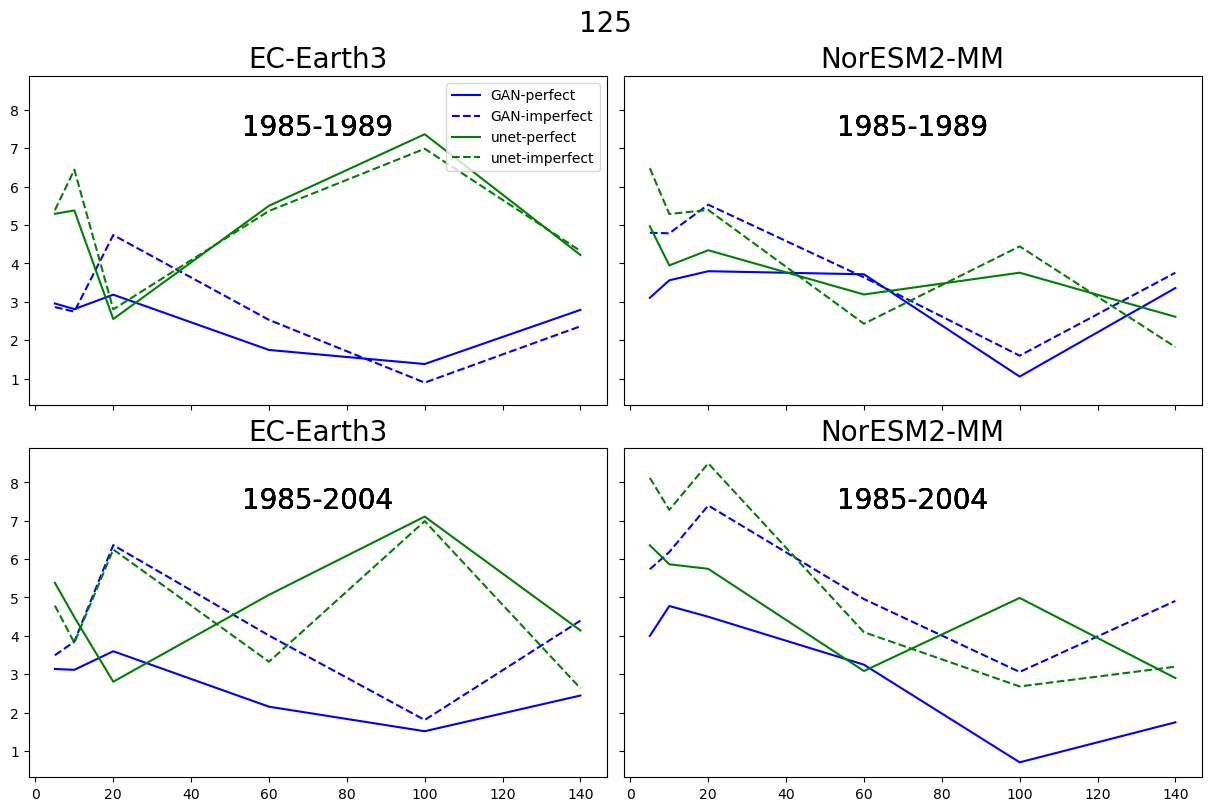

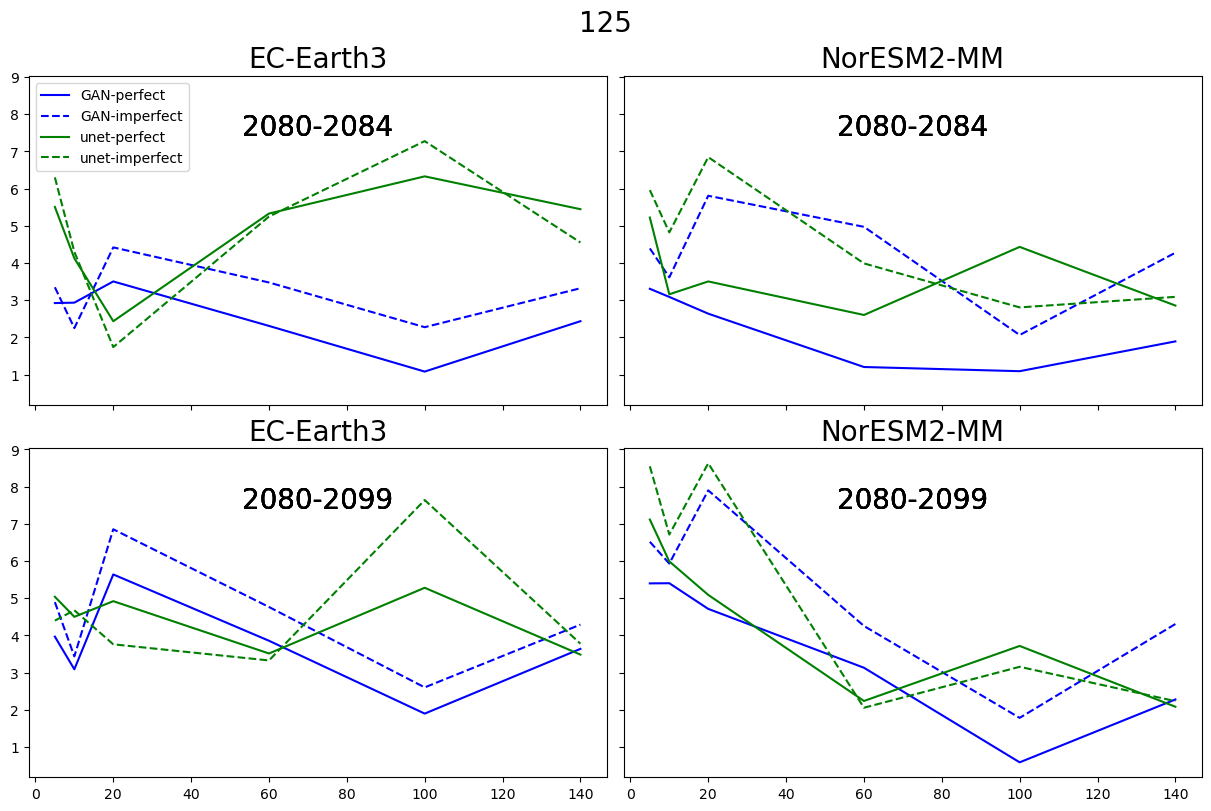

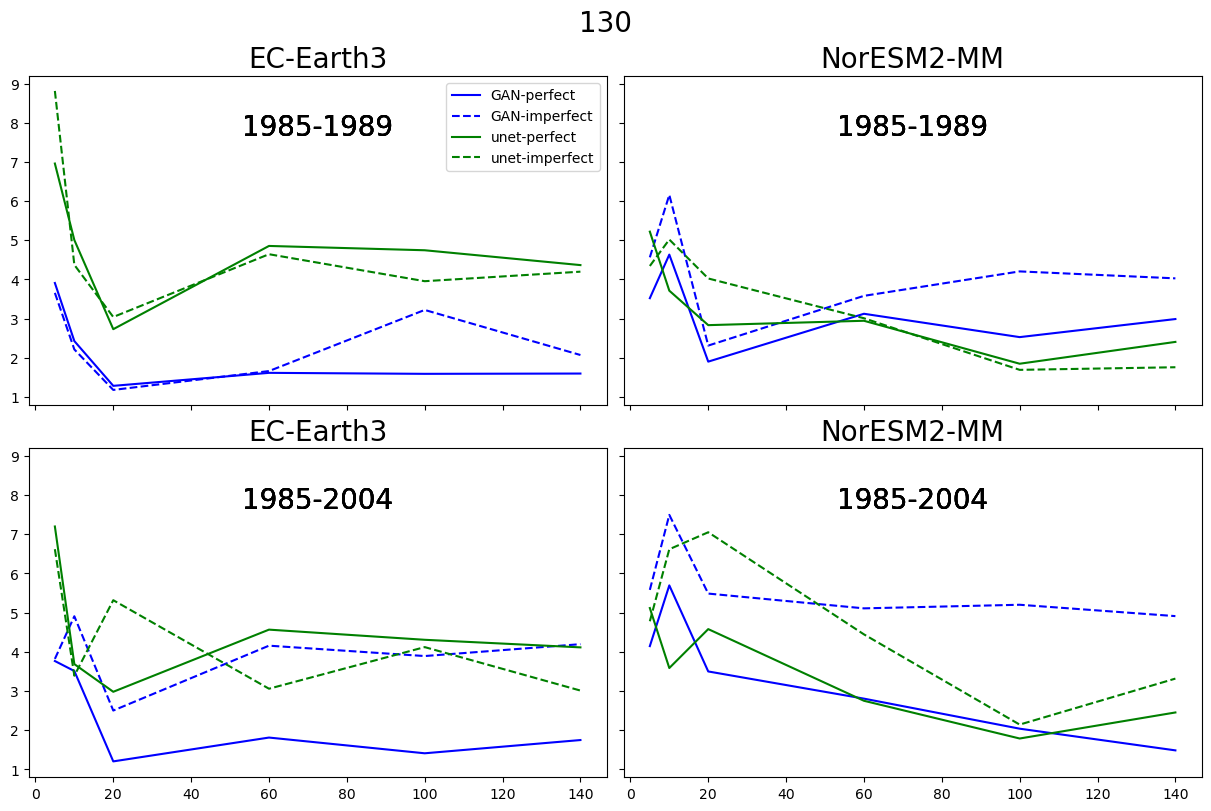

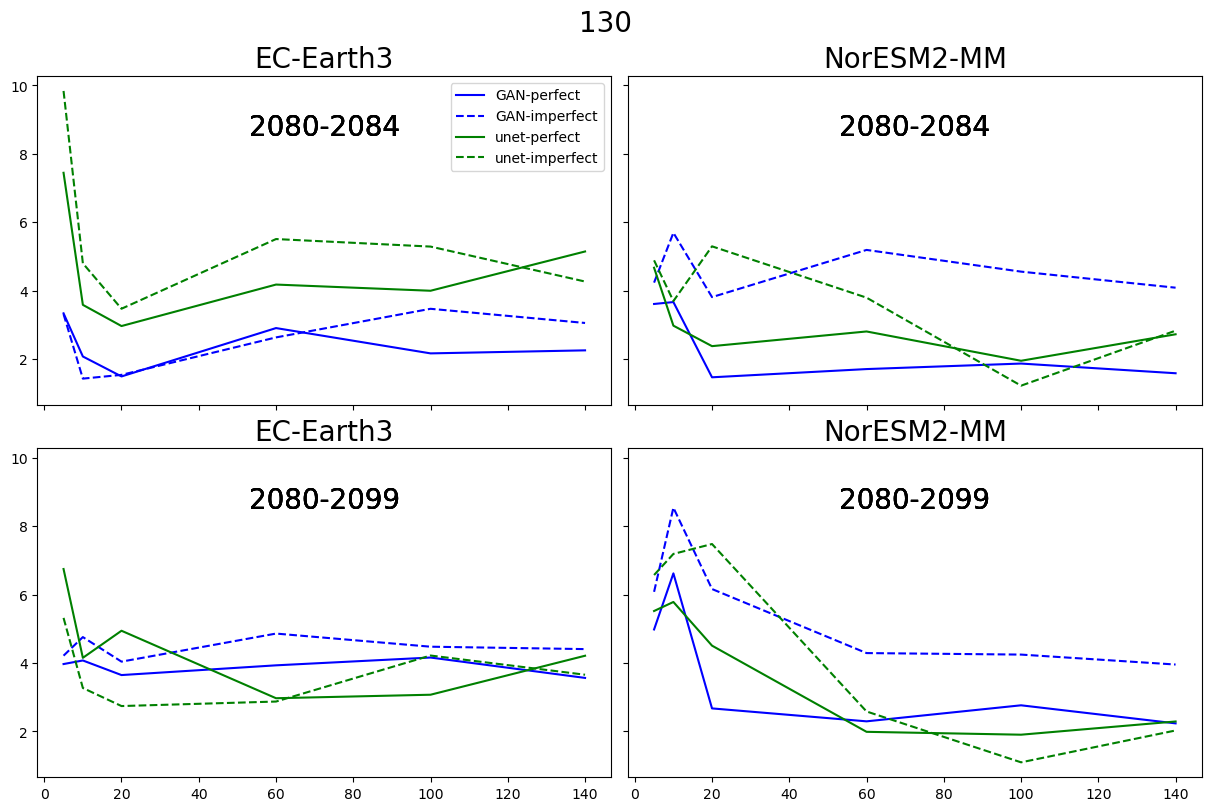

In [6]:

period_dict = {'historic':[('1985','1989'),('1985','2004')],'future':[('2080','2084'),('2080','2099')]}

for epoch in [120,125,130]:
    
    for scen in ['historic','future']:
        
        fig,axs = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True,layout='constrained')
        
        periods = period_dict[scen]
    
        for i,period in enumerate(periods):
            start,end = period

            df = get_lhd_df(start,end)

            for j,gcm in enumerate(['EC-Earth3','NorESM2-MM']):

                for ml_type in ['GAN','unet']:

                    for framework in ['perfect','imperfect']:

                        vals = (df[(df['ml_type']==ml_type) & (df['framework']==framework) & (df['GCM']==gcm) & (df['epoch']==epoch)])['lhd_db']
                        n = (df[(df['ml_type']==ml_type) & (df['framework']==framework) & (df['GCM']==gcm) & (df['epoch']==epoch)])['sample_n']

                        axs[i][j].plot(n,vals,color='blue' if ml_type == 'GAN' else 'green',linestyle = '-' if framework=='perfect' else '--',label=f'{ml_type}-{framework}')

                        axs[i][j].set_title(gcm,fontsize=20)

                        axs[i][j].text(0.5,0.8,f'{start}-{end}', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=20)


        axs[0][0].legend()
        plt.suptitle(f'{epoch}',fontsize=20)

        plt.savefig(f'/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/LHD/epoch_{epoch}_{scen}.png',dpi=300)
        plt.close()
        

In [ ]:
 
def psd(y, bins=np.arange(0, 0.52, 0.02)):
    """
    Compute Power Spectral Density (PSD) of an image y.
 
    Args:
    - y: Input image with shape (time, lat, lon).
    - bins: Array of bin edges for binning the wavenumbers.
 
    Returns:
    - psd_array: Array of PSD values with shape (time, K), where K is sqrt(kx^2 + ky^2),
                 representing the wavenumber in X and Y.
 
    - bin_edges: Bin edges used for binning the wavenumbers.
    """
    # Compute 2D FFT of the input image
    ffts = np.fft.fft2(y)
    ffts = np.fft.fftshift(abs(ffts) ** 2)
 
    # Compute the frequency grids
    freq = np.fft.fftshift(np.fft.fftfreq(172))
    freq2 = np.fft.fftshift(np.fft.fftfreq(179))
    kx, ky = np.meshgrid(freq, freq2)
    kx = kx.T
    ky = ky.T
 
    # Compute PSD by binning wavenumbers
    x = [
        binned_statistic(
            np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
            values=np.vstack(ffts[i].ravel()).T,
            statistic="mean",
            bins=bins,
        ).statistic
        for i in range(ffts.shape[0])
    ]
 
    # Compute PSD for the last time step (for normalization)
    x2 = binned_statistic(
        np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
        values=np.vstack(ffts[-1].ravel()).T,
        statistic="mean",
        bins=bins,
    )
 
    # Normalize the PSD and return it along with bin edges
    return np.array(x)[:, 0, :] / abs(x2.bin_edges[0] - x2.bin_edges[1]), x2.bin_edges